# Choose a dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_s_curve
import torch

shape of curve: (10000, 2)


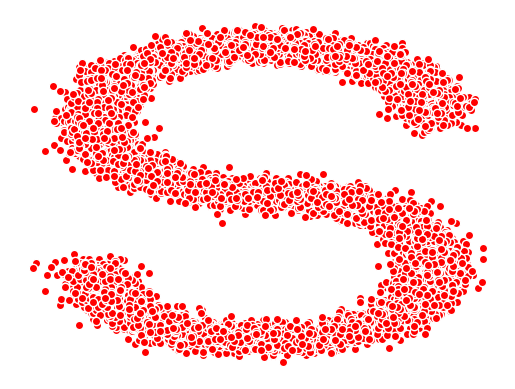

In [2]:
s_curve, _ = make_s_curve(10**4,  noise=0.1)
s_curve = s_curve[:, [0,2]] / 10.0 # first and second dimension
print(f"shape of curve: {s_curve.shape}")

data = s_curve.T

fig, ax = plt.subplots()
ax.scatter(*data, color="red", edgecolor="white")

ax.axis("off")

dataset = torch.Tensor(s_curve).float()


# Hyperparameters

In [3]:
num_steps = 100

betas = torch.linspace(-6, 6, num_steps)
betas = torch.sigmoid(betas) * (0.5e-2 - 1e-5) + 1e-5

alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0)  # cummulative product
alphas_bar_sqrt = torch.sqrt(alphas_bar)

one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_bar)

assert alphas.shape == alphas_bar.shape == alphas_bar_sqrt.shape == \
     one_minus_alphas_bar_sqrt.shape
print(f"all the same shape: {betas.shape}")

all the same shape: torch.Size([100])


# Forward: Diffusion

## 1. Diffusion at time t

In [4]:
def q_x(x0, t):
    """ xt = sqrt(alpha_bar) * x0 +  sqrt(1 - alpha_bar) * noise """

    noise = torch.randn_like(x0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]

    return alphas_t * x0 + alphas_1_m_t * noise

In [5]:
#计算任意时刻的x采样值，基于x_0和重参数化
def q_x(x_0,t):
    """可以基于x[0]得到任意时刻t的x[t]"""
    noise = torch.randn_like(x_0)
    alphas_t = alphas_bar_sqrt[t]
    alphas_1_m_t = one_minus_alphas_bar_sqrt[t]
    return (alphas_t * x_0 + alphas_1_m_t * noise)#在x[0]的基础上添加噪声
    

## 2. Display Origina Data during 100 times forward

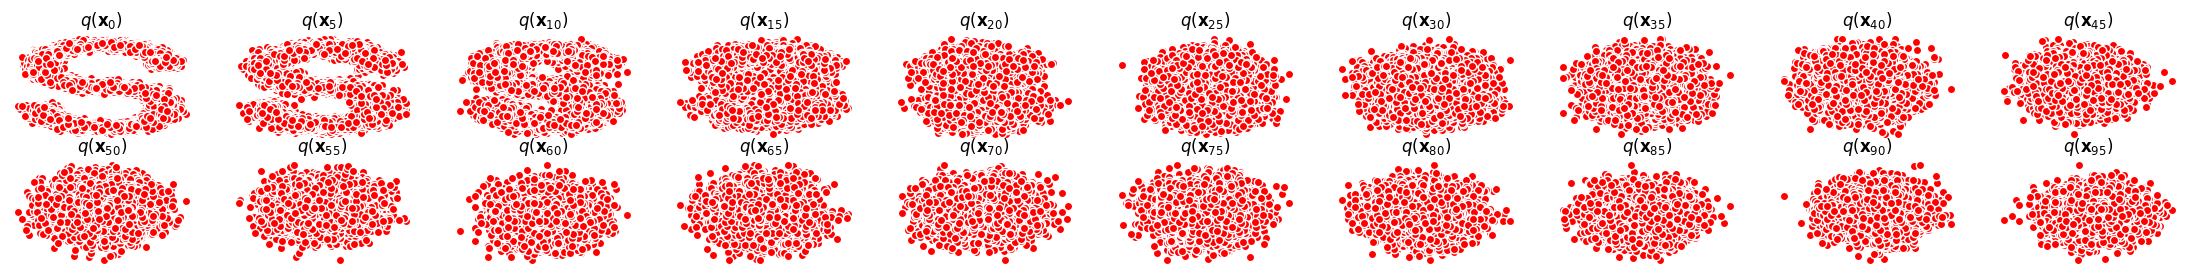

In [6]:
num_show = 20
fig, axs = plt.subplots(2, 10, figsize=(28,3))
plt.rc('text', color='black')

for i in range(num_show):
    j = i // 10
    k = i % 10
    q_i = q_x(dataset, torch.tensor([i * num_steps // num_show]))
    axs[j,k].scatter(q_i[:,0], q_i[:,1], color='red', edgecolor="white")
    axs[j,k].set_axis_off()
    axs[j,k].set_title("$q(\mathbf{x}_{" + str(i*num_steps//num_show) + "})$")

# Reverse: sampling

In [7]:
import torch
import torch.nn as nn

class MLPDiffusion(nn.Module):
    """ fit Gaussian noise. """

    def __init__(self, n_steps, num_units=128):
        super(MLPDiffusion, self).__init__()

        self.linears = nn.ModuleList(
            [
                nn.Linear(2, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, num_units),
                nn.ReLU(),
                nn.Linear(num_units, 2)
            ]
        )

        # time embedding, let model better understand time step
        self.step_embeddings = nn.ModuleList(
            [
                nn.Embedding(n_steps, num_units),   # position, dimension
                nn.Embedding(n_steps, num_units),
                nn.Embedding(n_steps, num_units),
            ]
        )

    def forward(self, x, t):
        for idx, embedding_layer in enumerate(self.step_embeddings):
            t_embedding = embedding_layer(t)
            x = self.linears[2*idx](x)
            x += t_embedding
            x = self.linears[2*idx+1](x)

        x = self.linears[-1](x)
        return x # gaussian noise

## 2. loss function

In [8]:
def loss_func(model, x0, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, n_steps):
    
    batch_size = x0.shape[0]

    # random time [batchsize, 1]
    t = torch.randint(0, n_steps, size=(batch_size//2,))  # gen half of t
    t = torch.cat([t, n_steps-1-t], dim=0)  # take complement, cover more t
    t = t.unsqueeze(-1)

    # coeffiecient of x0
    a = alphas_bar_sqrt[t]

    # coefficient of epsilon
    am1 = one_minus_alphas_bar_sqrt[t]

    # randomly generate noise epsilon: ground truth
    z_gt = torch.randn_like(x0)

    # model input: x_t
    x_t = a * x0 + z_gt * am1

    # model output: predict z_t
    z_t_predict = model(x_t, t.squeeze(-1)) # why squeeze

    # MSE
    return (z_gt - z_t_predict).square().mean()

## Inference: reverse sampling

In [9]:
def p_sample_loop(model, shape, n_steps, betas, one_minus_alphas_bar_sqrt):
    """ Reversely infer x_t-1, x_t-2, ..., x_0 from x_t. """
    
    current_x = torch.randn(shape)
    x_seq = [current_x]
    for i in reversed(range(n_steps)):
        current_x = p_sample(model, current_x, 
                             t=i, 
                             betas=betas, 
                             one_minus_alphas_bar_sqrt=one_minus_alphas_bar_sqrt)
        x_seq.append(current_x)

    return x_seq


def p_sample(model, x, t, betas, one_minus_alphas_bar_sqrt):
    """ sampling value from Xt at time t. Reparameterization. """

    t = torch.tensor([t])
    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]
    z_theta = model(x, t) # predict noise
    mean_t = 1 / (1-betas[t]).sqrt() * (x - coeff * z_theta)
    
    epsilon = torch.randn_like(x)
    sigma_t = betas[t].sqrt() 

    sample = mean_t + sigma_t * epsilon
    return sample

## Train Model

Training Model...


/Users/yuxinli/opt/anaconda3/envs/EEGSDE/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


epoch: 0, Loss: 0.7277604341506958
epoch: 100, Loss: 0.48146823048591614
epoch: 200, Loss: 0.4670487940311432
epoch: 300, Loss: 0.31233450770378113
epoch: 400, Loss: 0.26241520047187805
epoch: 500, Loss: 0.2466706931591034
epoch: 600, Loss: 0.363687127828598
epoch: 700, Loss: 0.30546456575393677
epoch: 800, Loss: 0.24341516196727753
epoch: 900, Loss: 0.2850179076194763
epoch: 1000, Loss: 0.23252488672733307
epoch: 1100, Loss: 0.352814257144928
epoch: 1200, Loss: 0.40060338377952576
epoch: 1300, Loss: 0.28211867809295654
epoch: 1400, Loss: 0.17250920832157135
epoch: 1500, Loss: 0.43488842248916626
epoch: 1600, Loss: 0.5295882821083069
epoch: 1700, Loss: 0.3861965537071228
epoch: 1800, Loss: 0.20236845314502716
epoch: 1900, Loss: 0.2816733121871948
epoch: 2000, Loss: 0.37190109491348267


/Users/yuxinli/opt/anaconda3/envs/EEGSDE/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


epoch: 2100, Loss: 0.13110128045082092
epoch: 2200, Loss: 0.4234738349914551
epoch: 2300, Loss: 0.7174420952796936
epoch: 2400, Loss: 0.41073477268218994
epoch: 2500, Loss: 0.35584524273872375
epoch: 2600, Loss: 0.6640363931655884
epoch: 2700, Loss: 0.34891656041145325
epoch: 2800, Loss: 0.34540510177612305
epoch: 2900, Loss: 0.17616716027259827
epoch: 3000, Loss: 0.1428154557943344
epoch: 3100, Loss: 0.3831785321235657
epoch: 3200, Loss: 0.22467681765556335
epoch: 3300, Loss: 0.3641078770160675
epoch: 3400, Loss: 0.3491152226924896
epoch: 3500, Loss: 0.5929073691368103
epoch: 3600, Loss: 0.23853440582752228
epoch: 3700, Loss: 0.3753544092178345
epoch: 3800, Loss: 0.37292206287384033
epoch: 3900, Loss: 0.2849847078323364


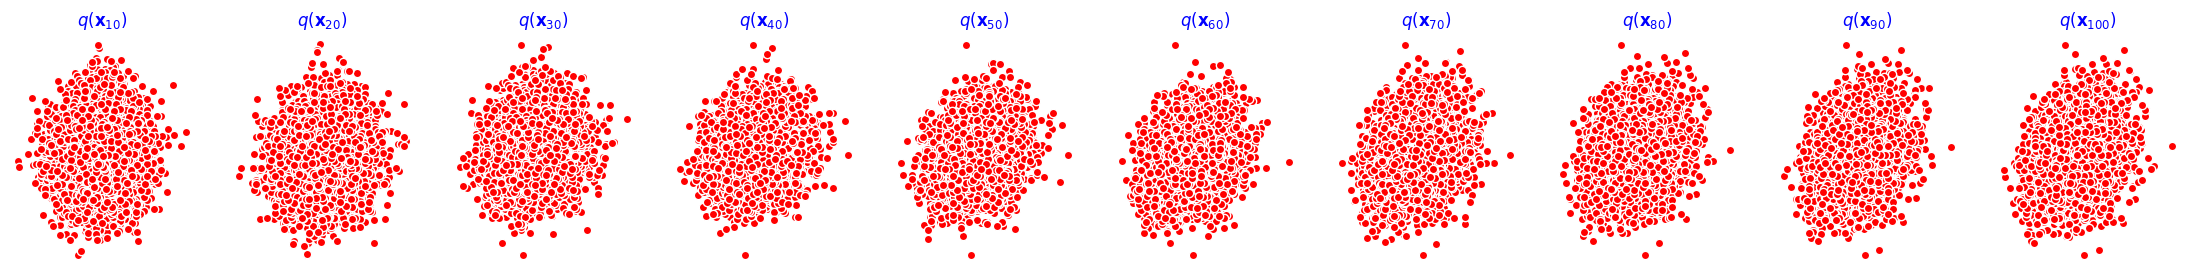

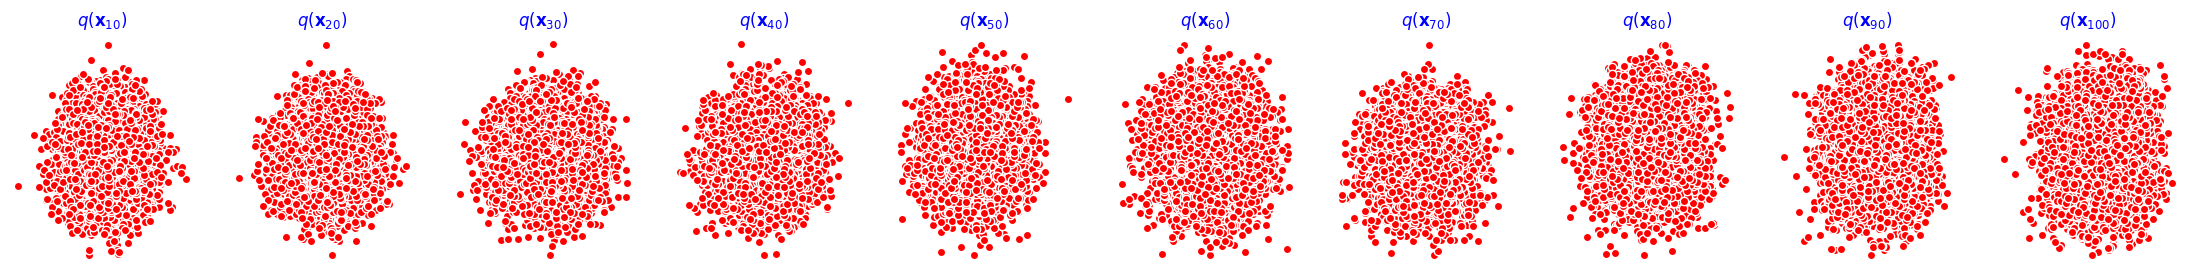

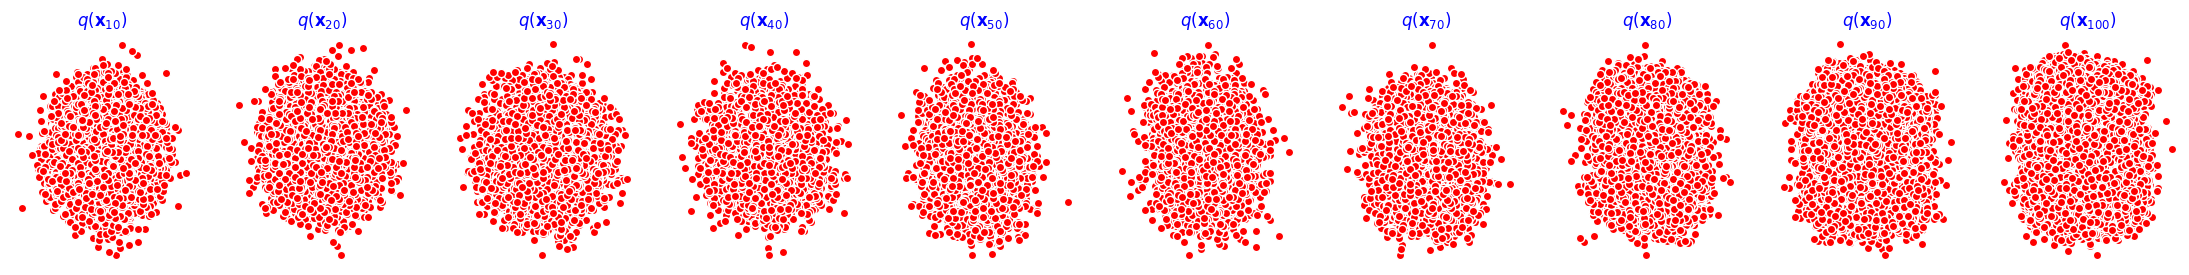

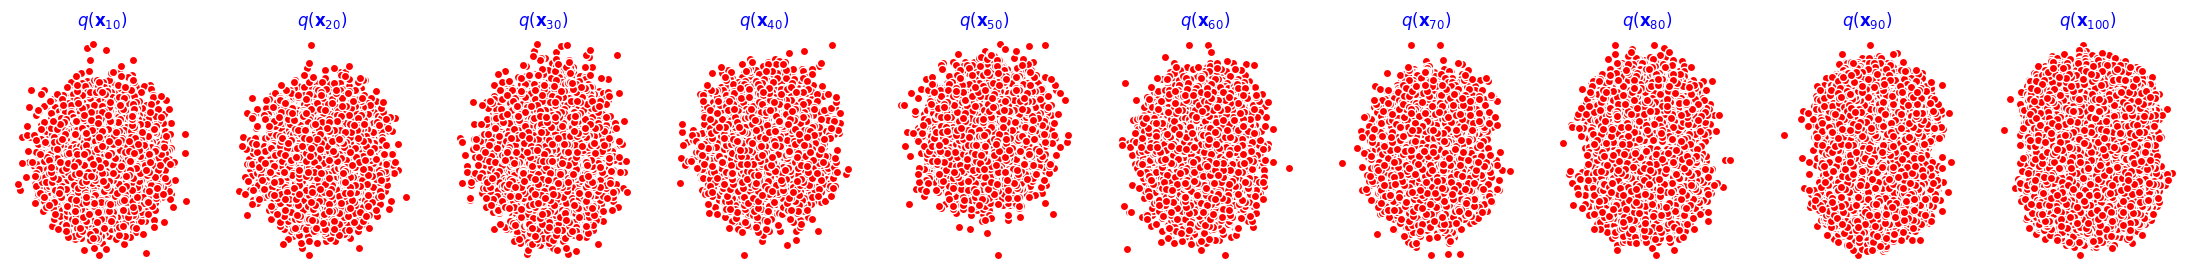

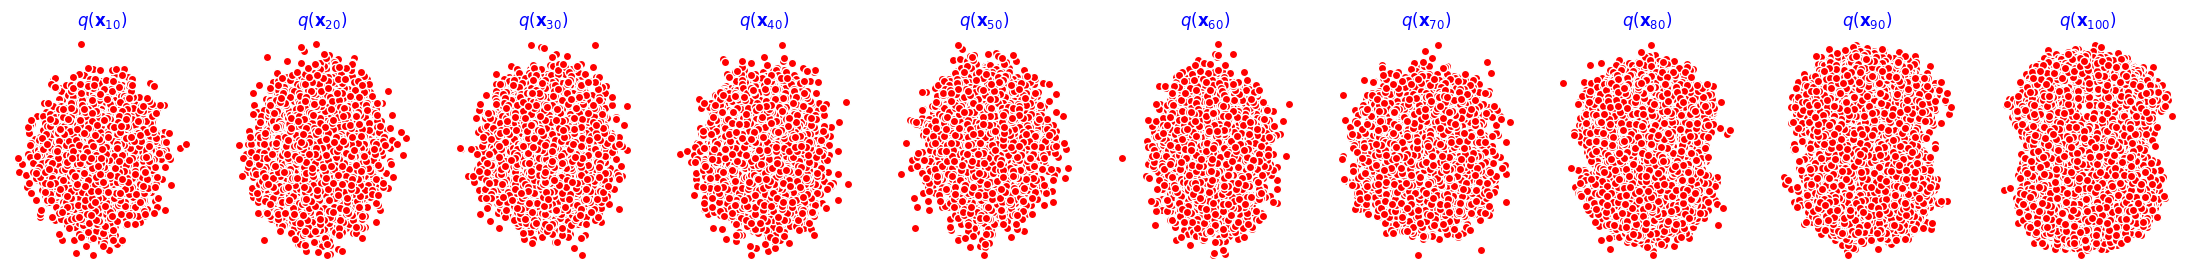

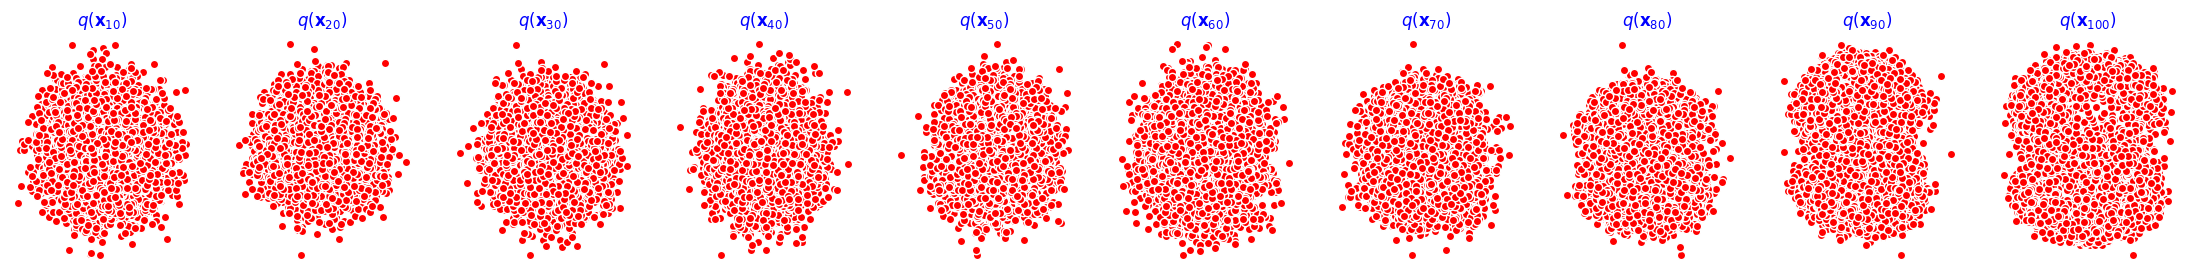

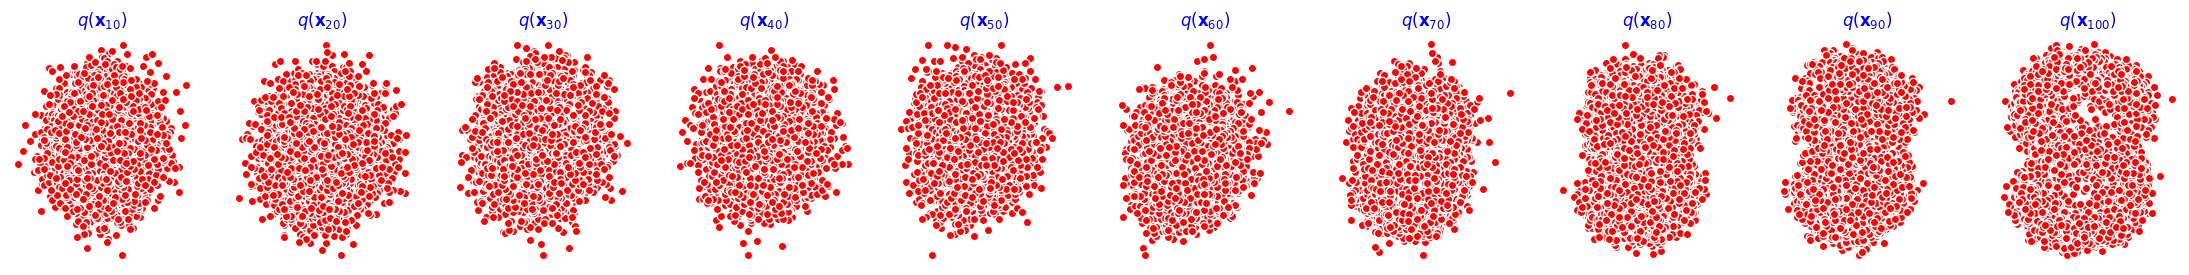

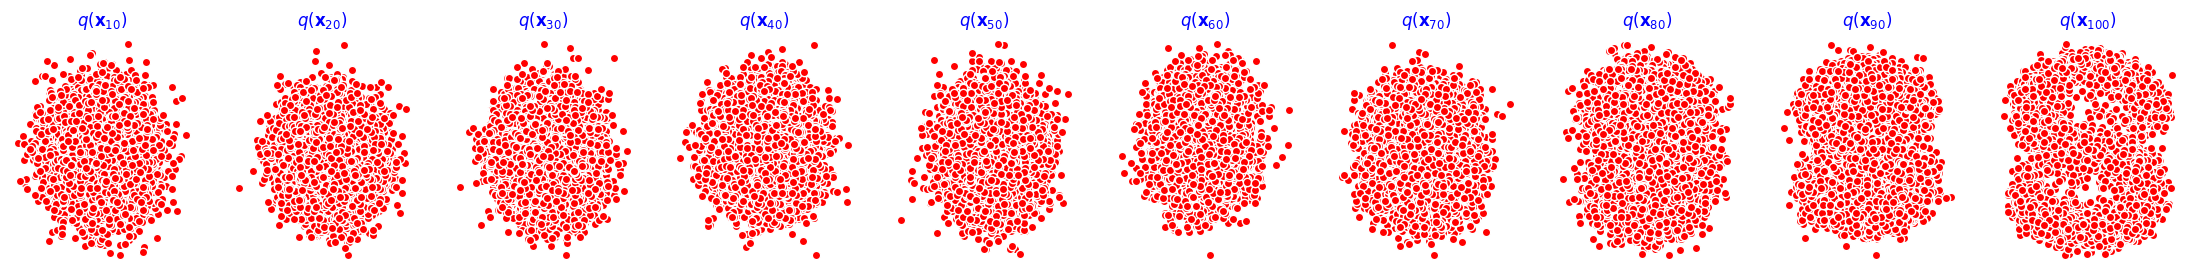

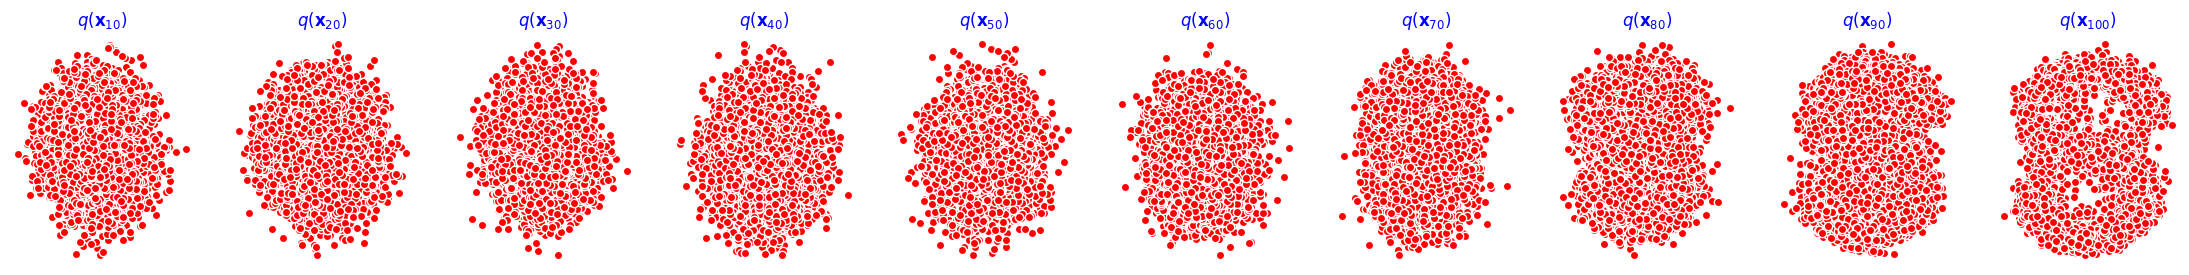

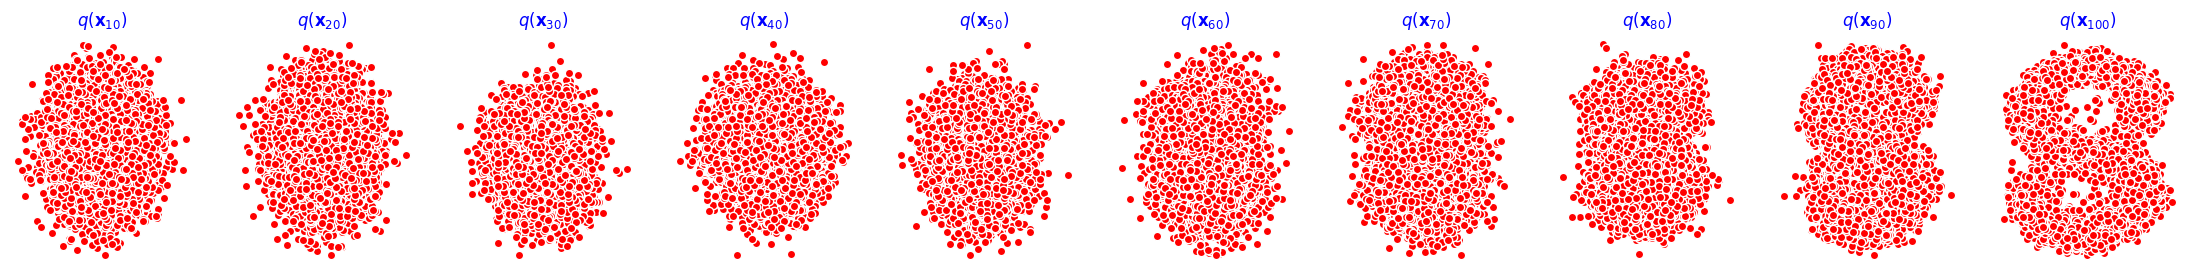

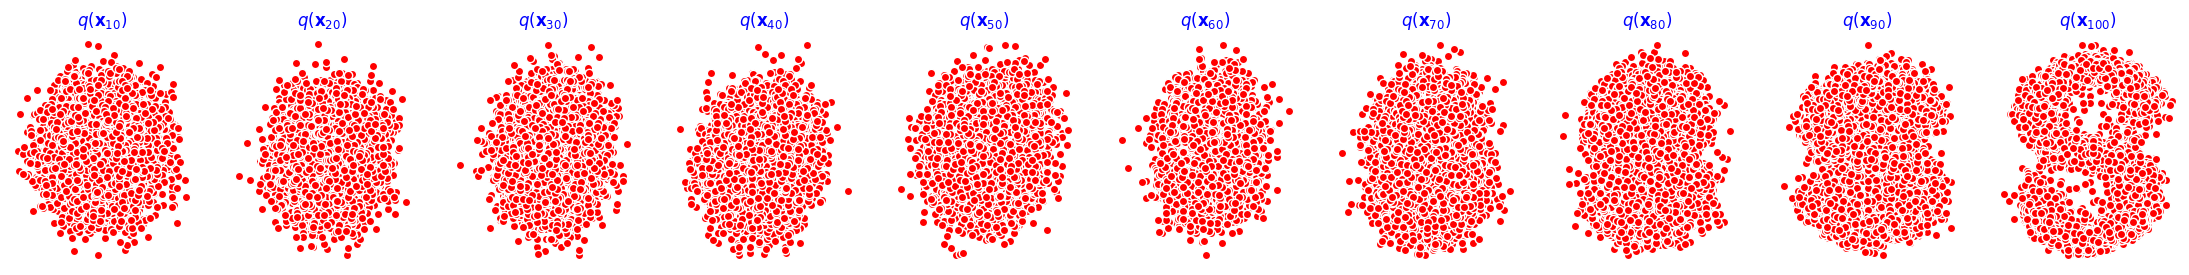

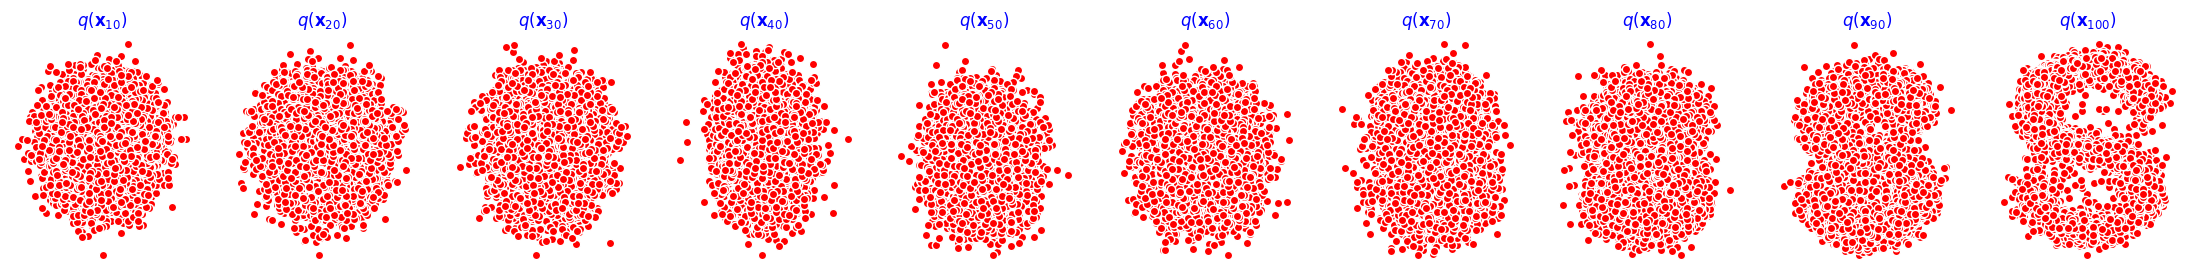

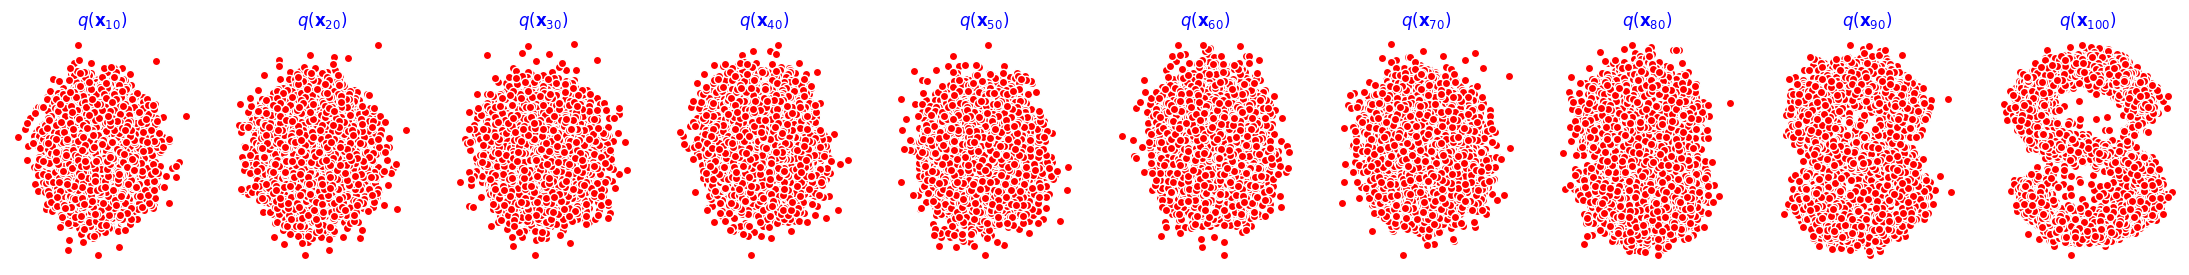

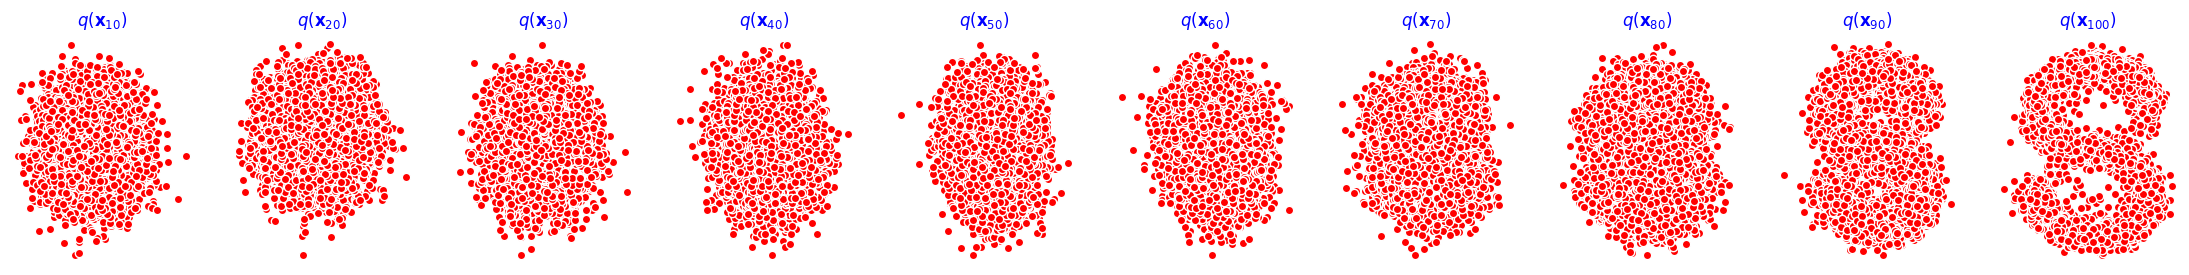

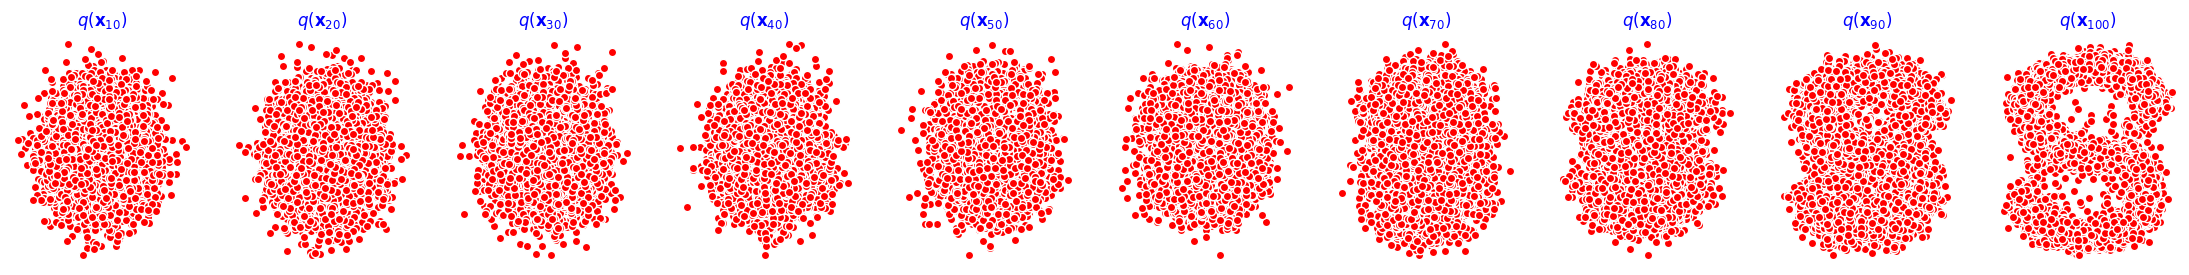

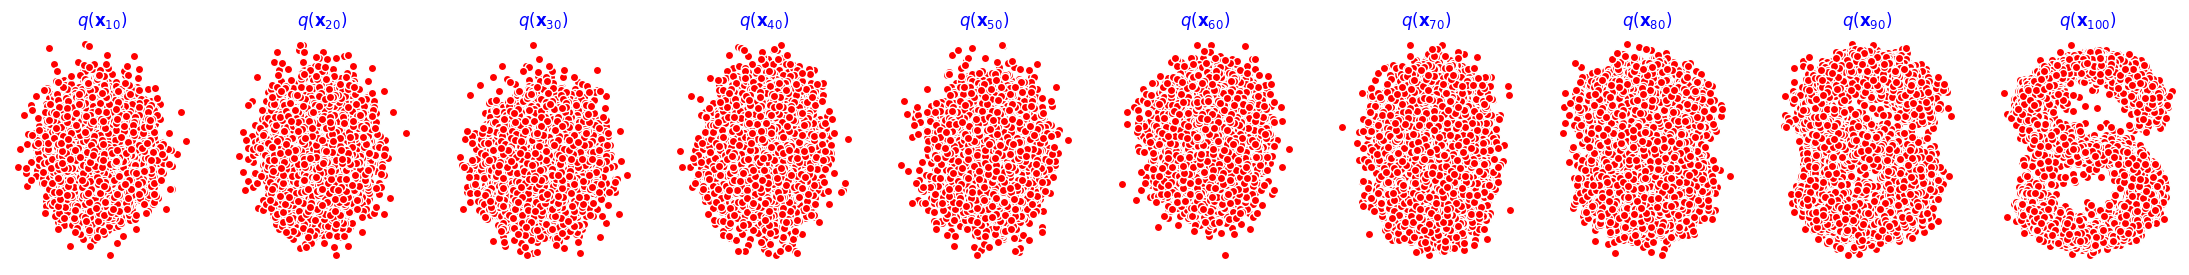

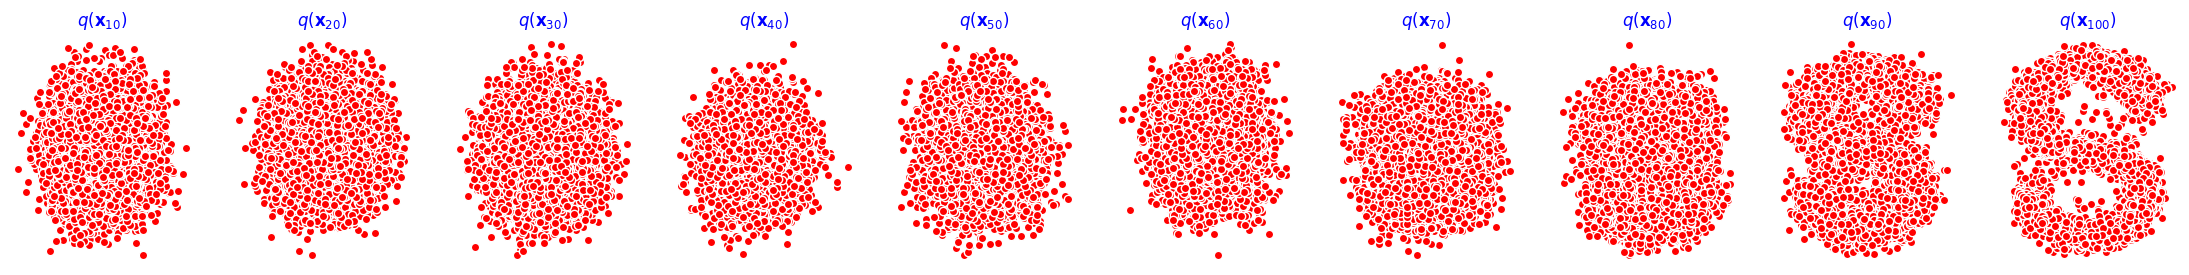

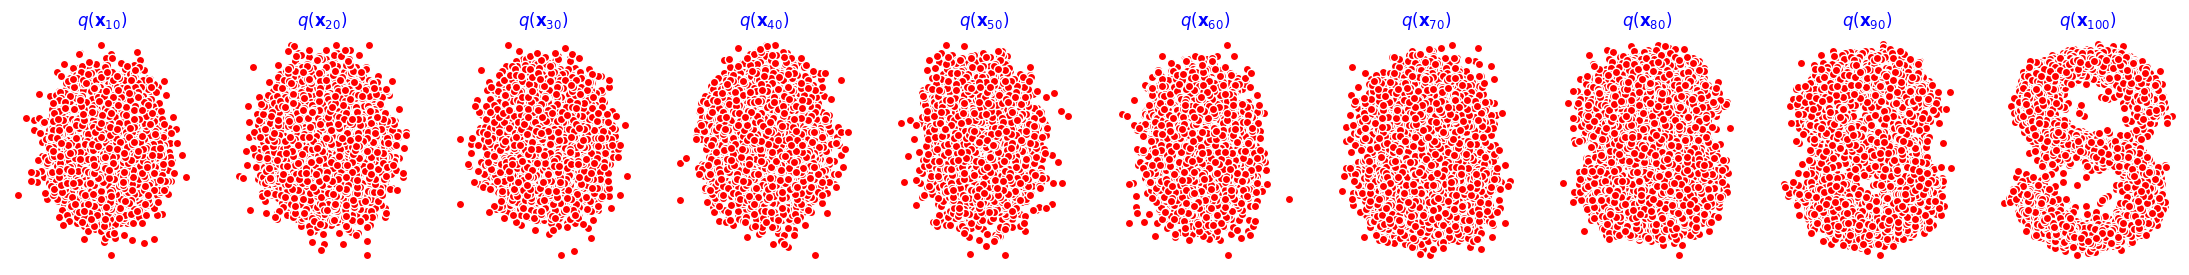

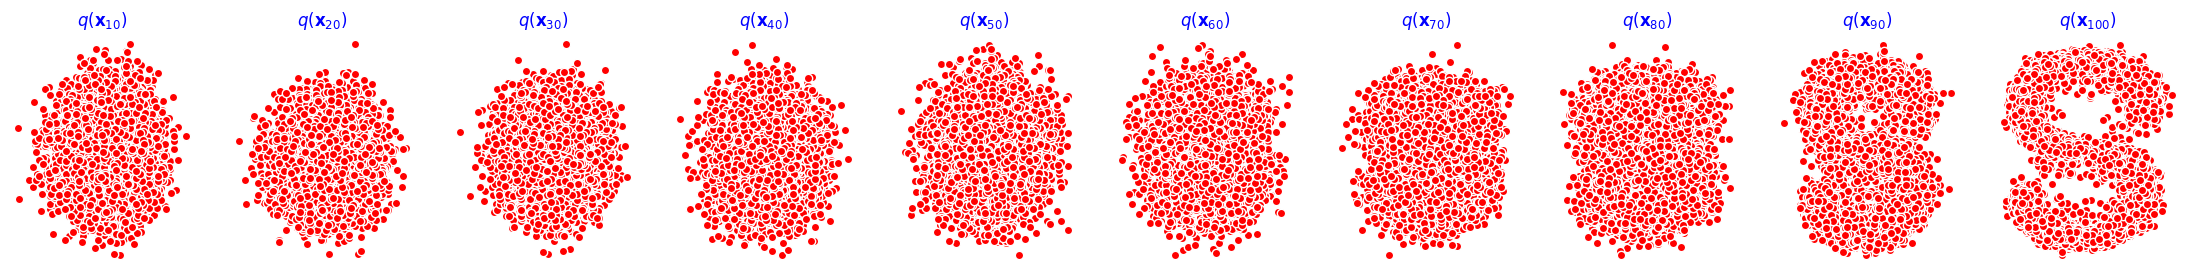

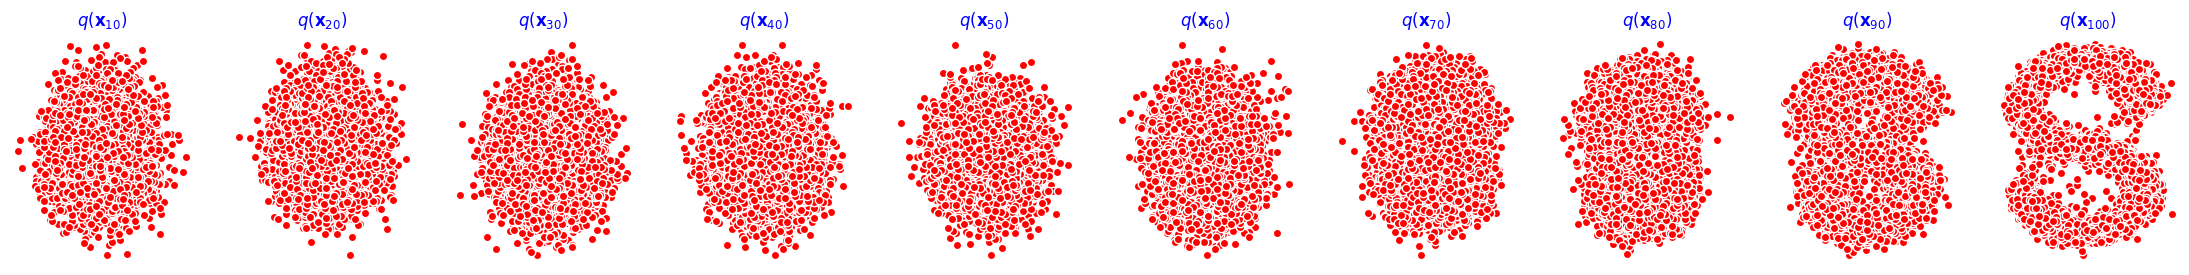

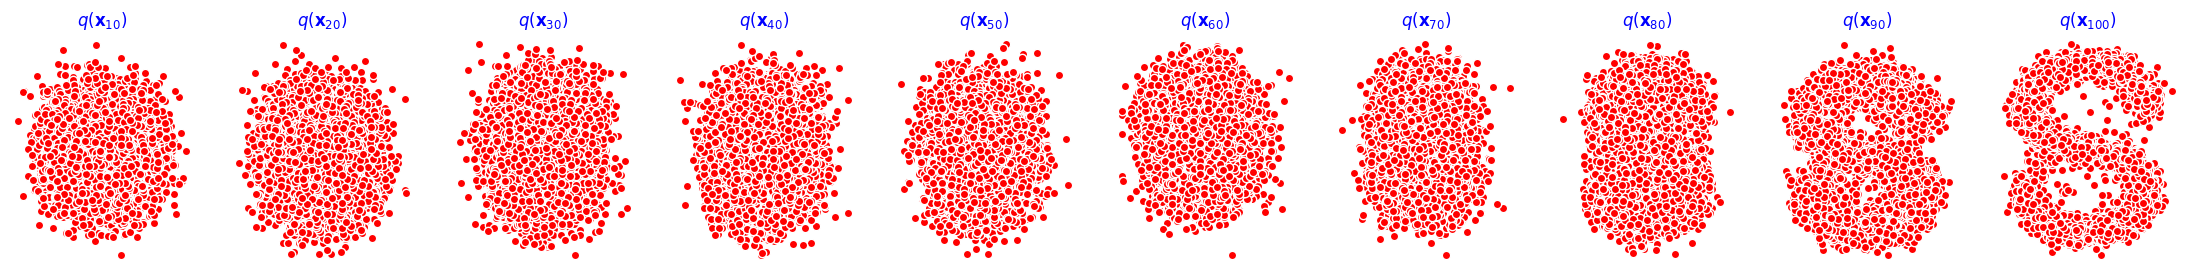

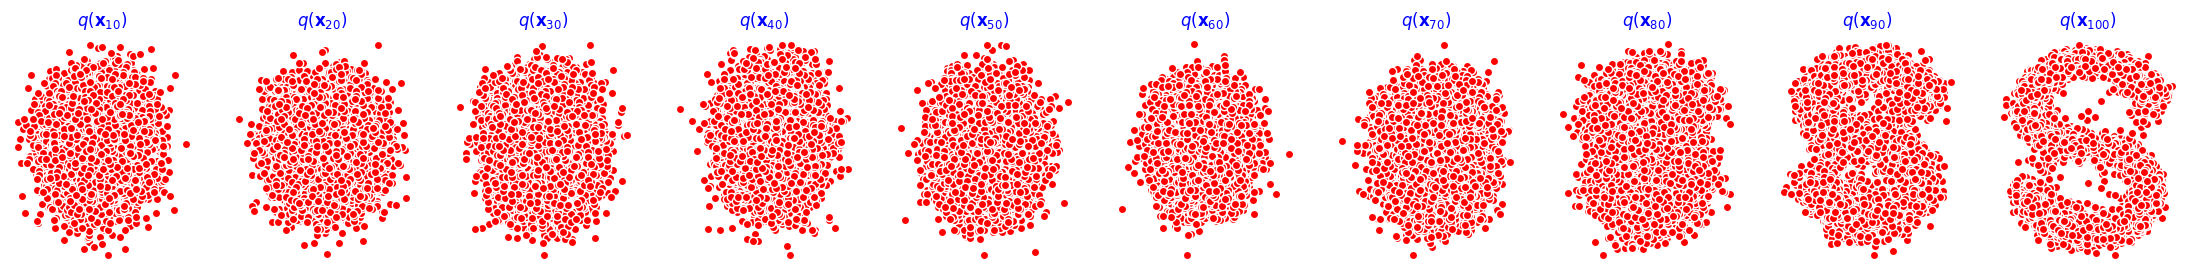

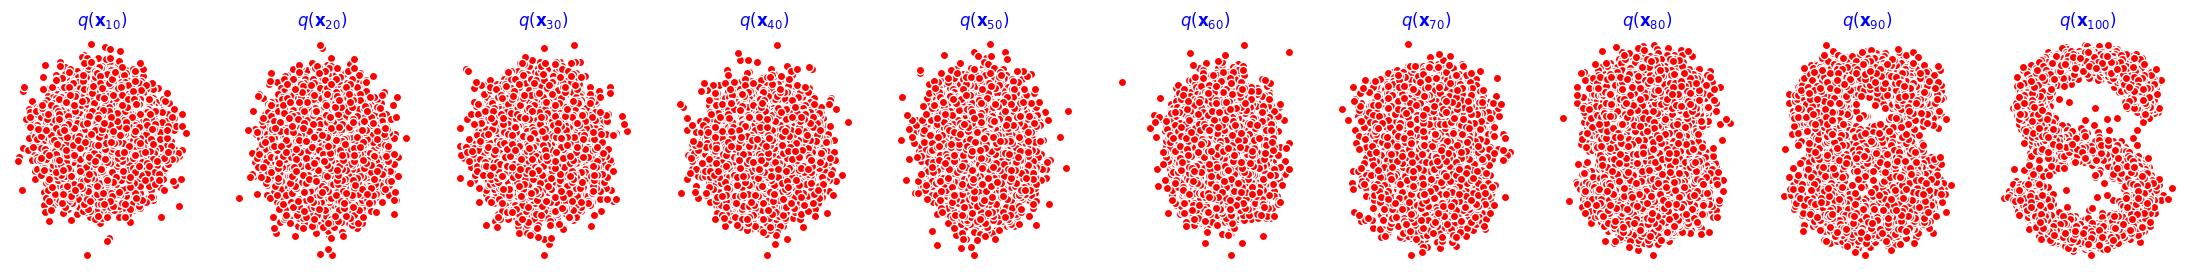

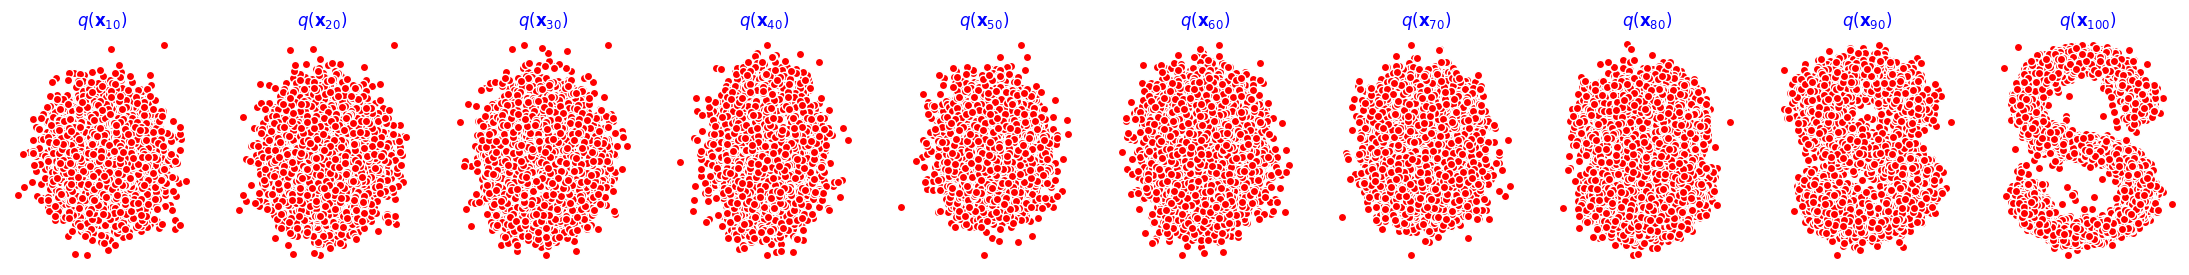

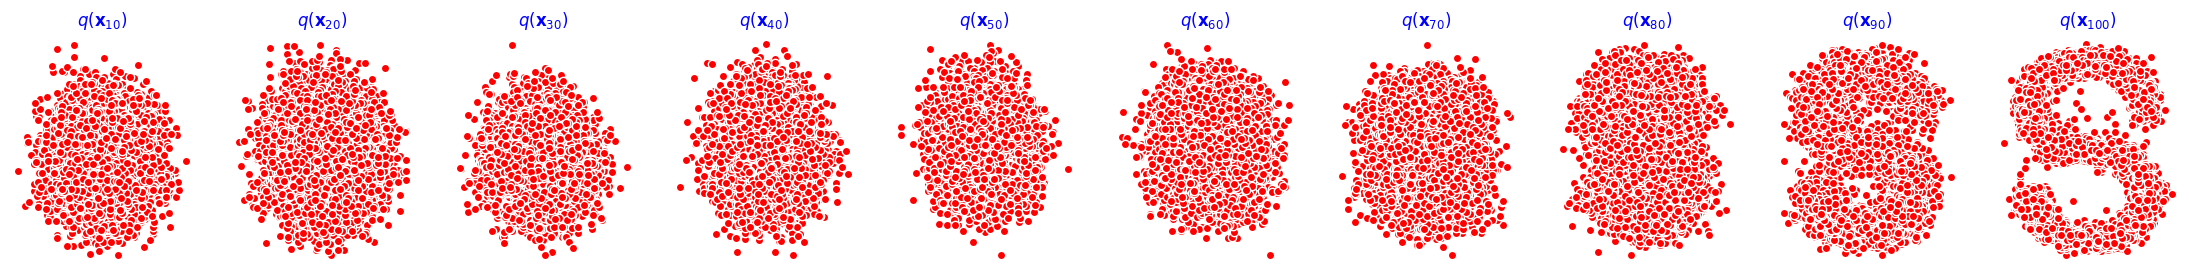

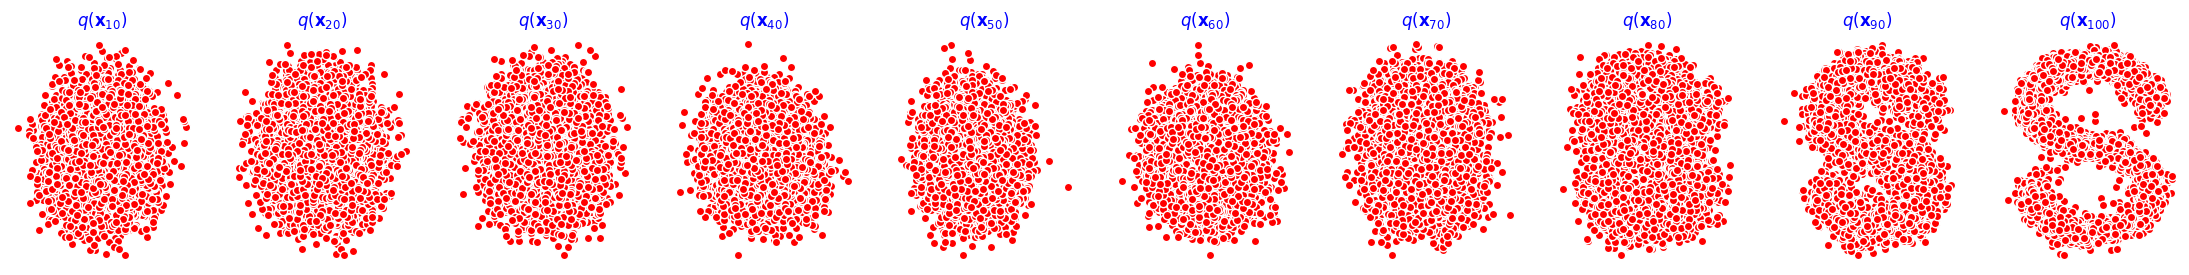

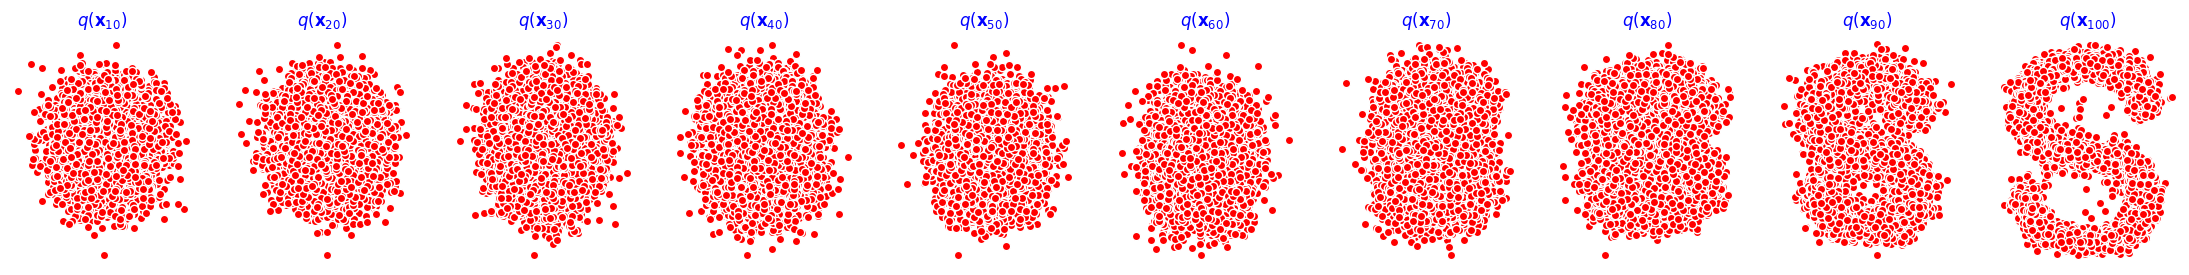

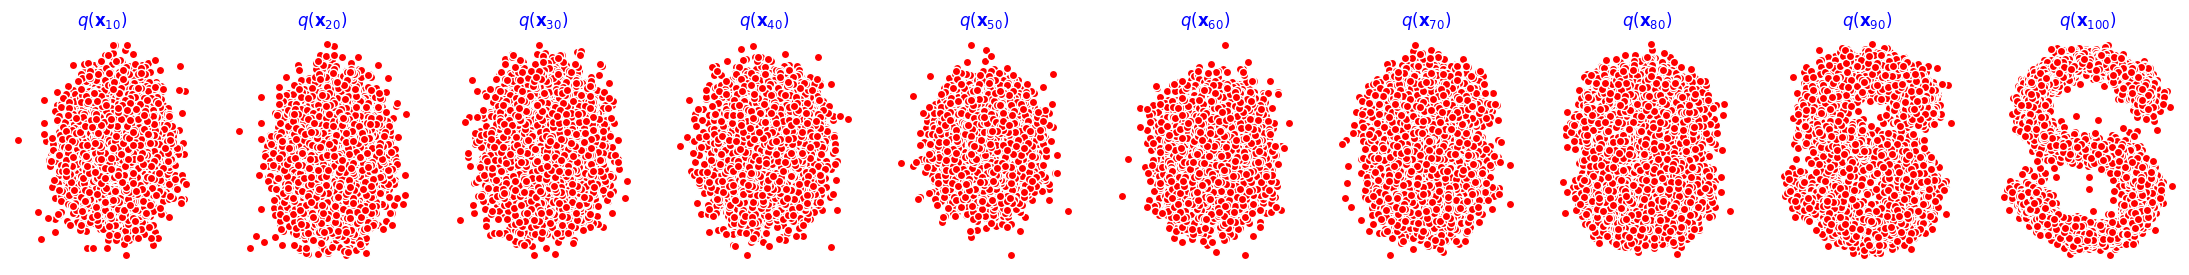

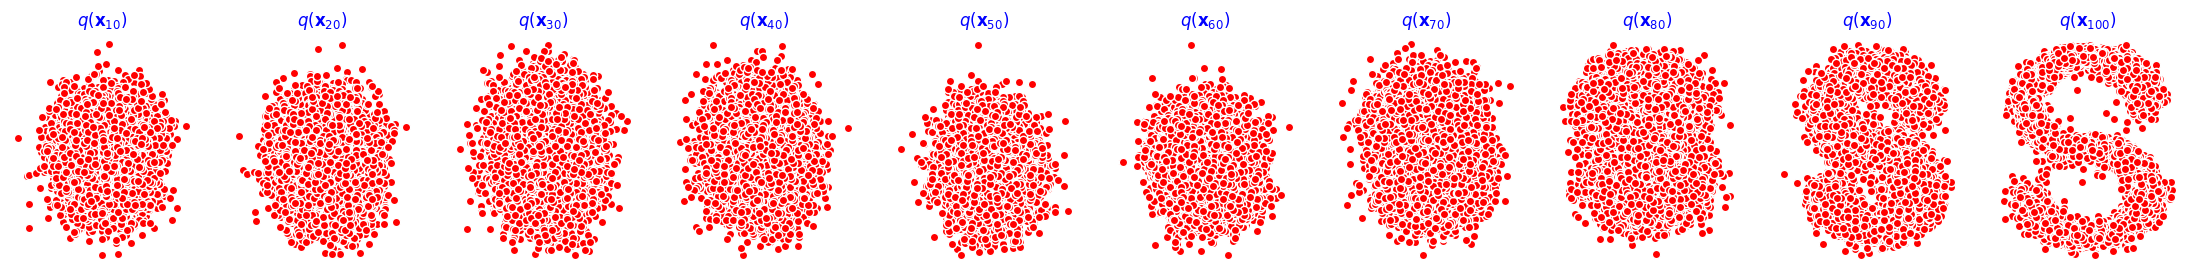

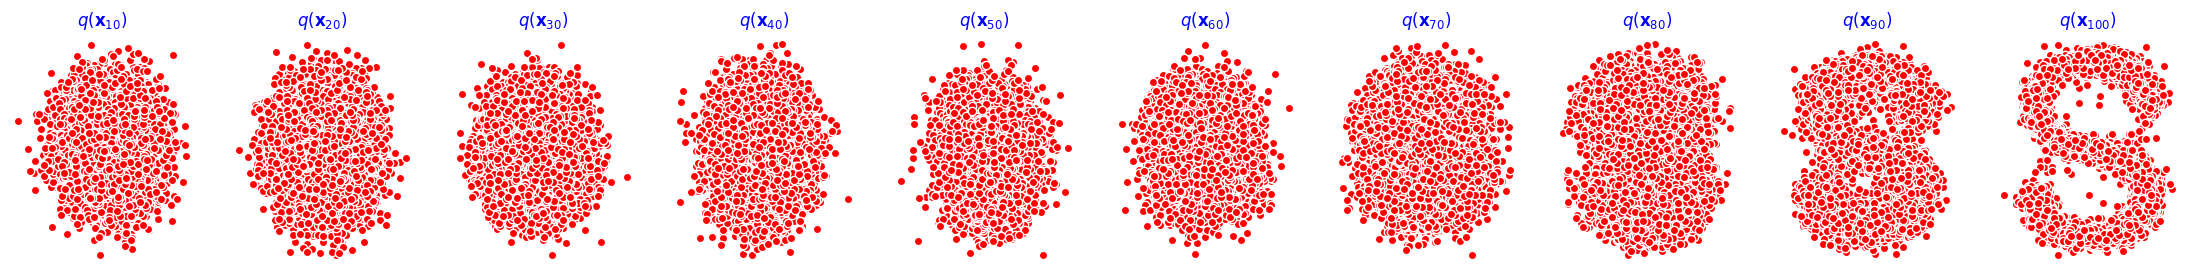

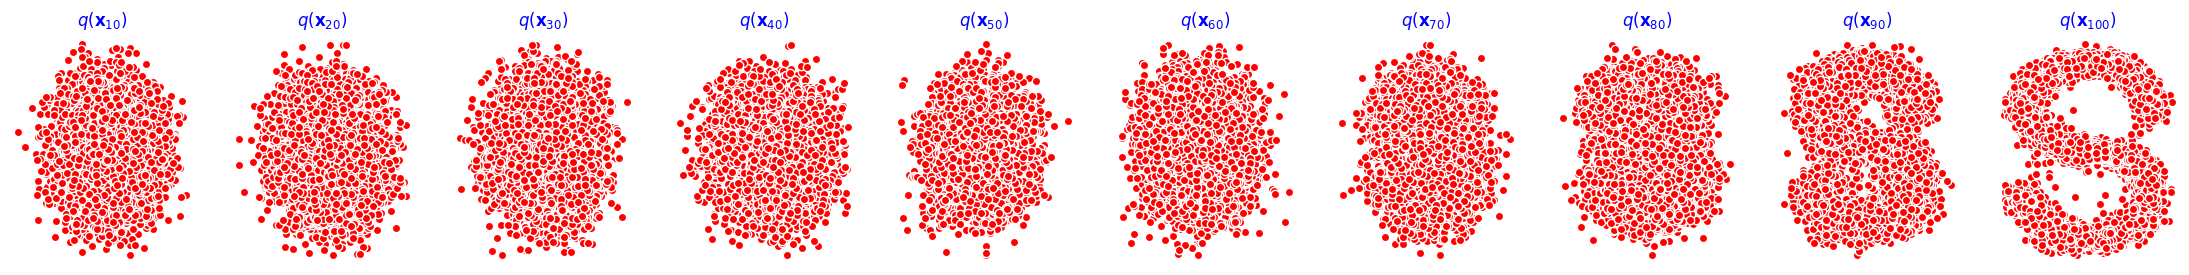

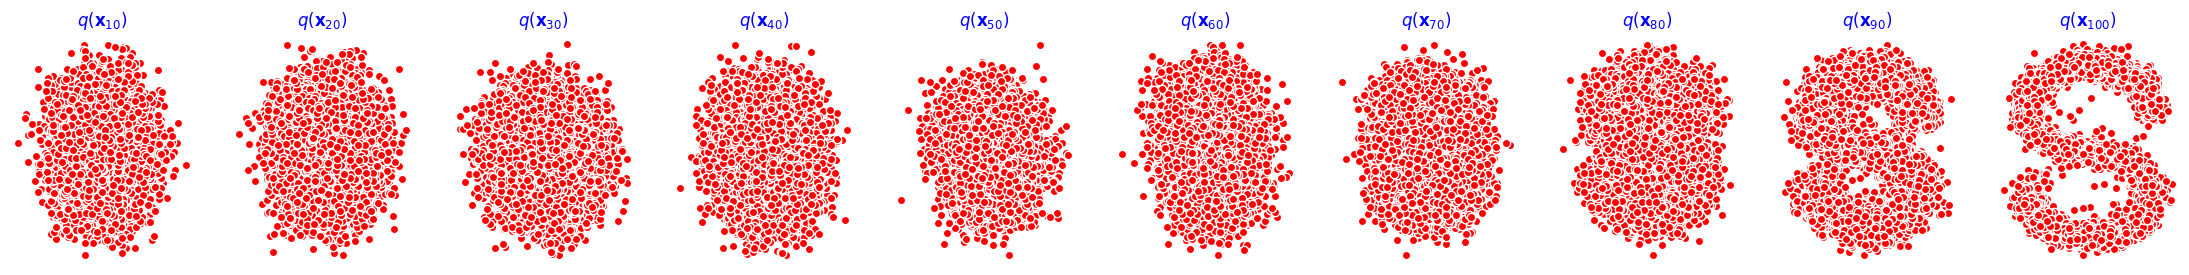

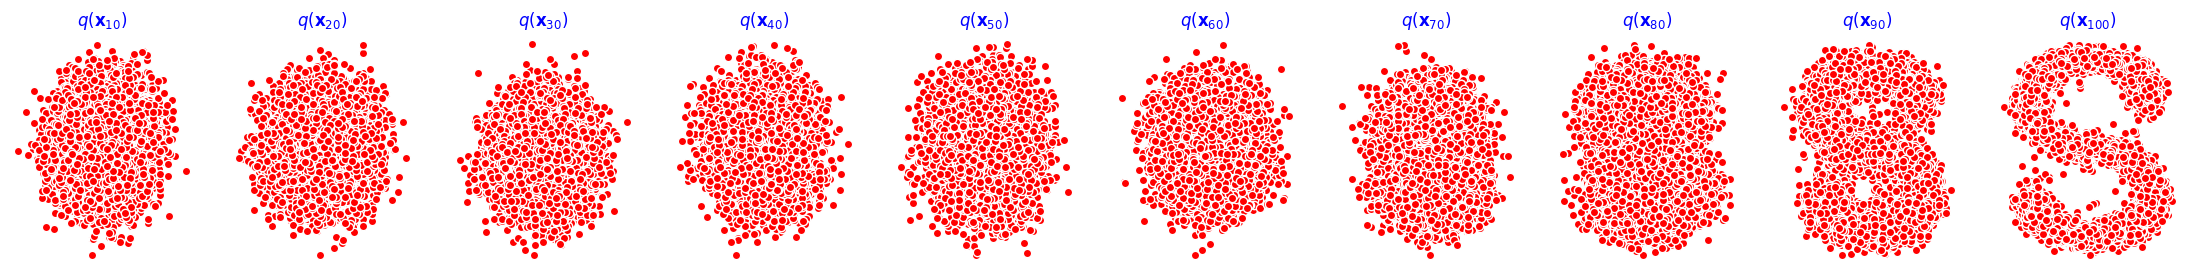

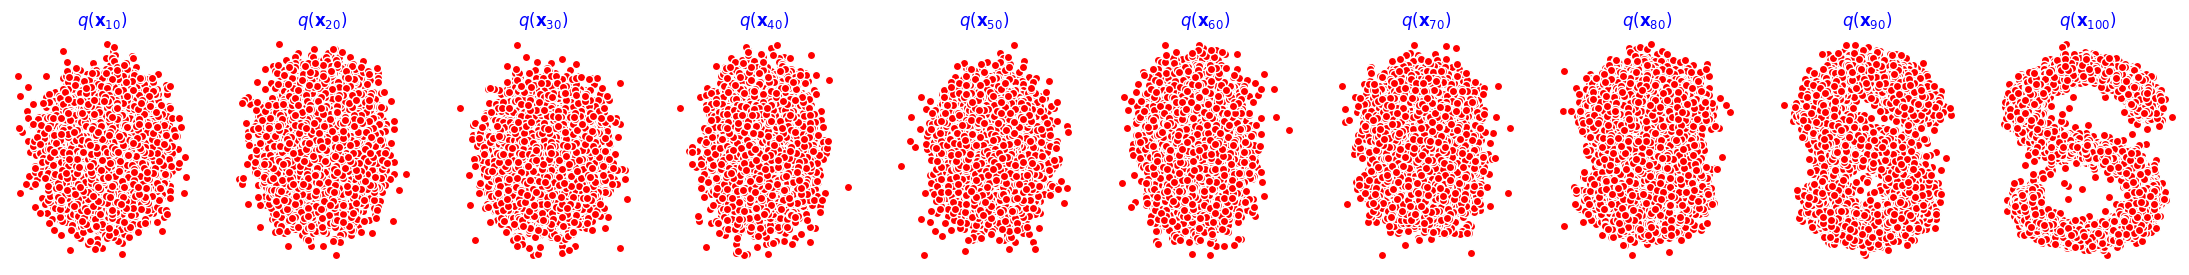

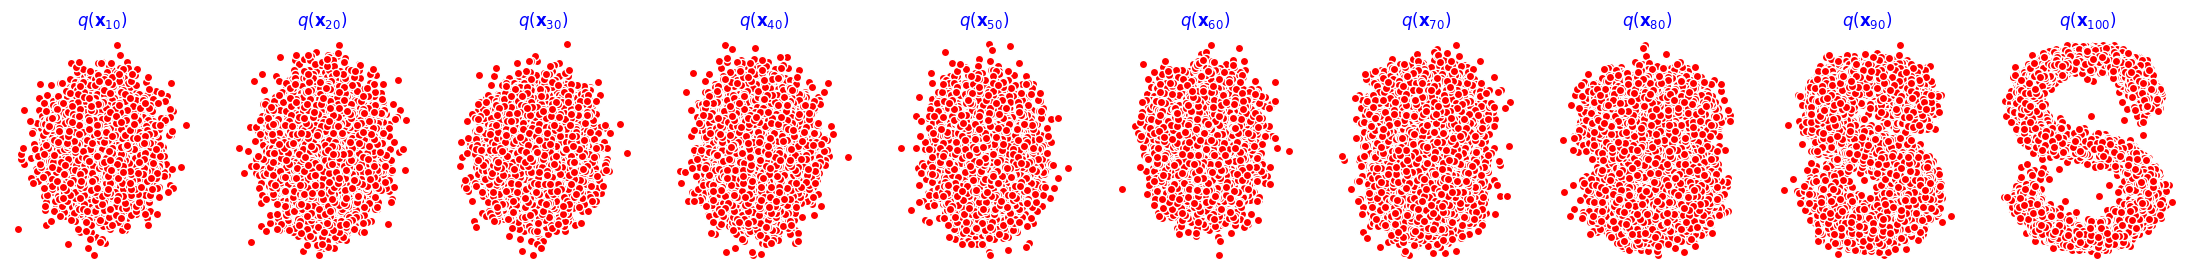

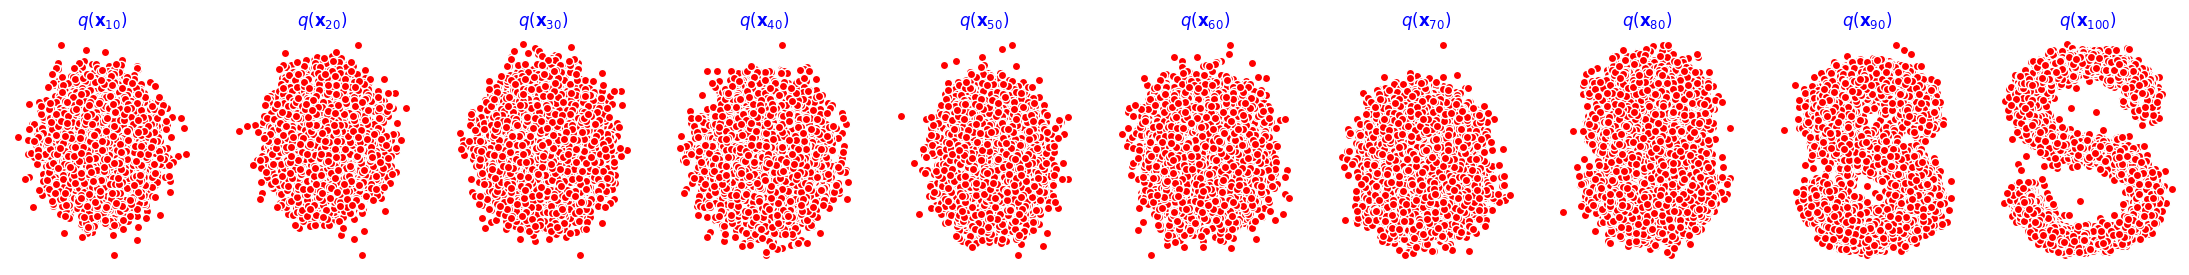

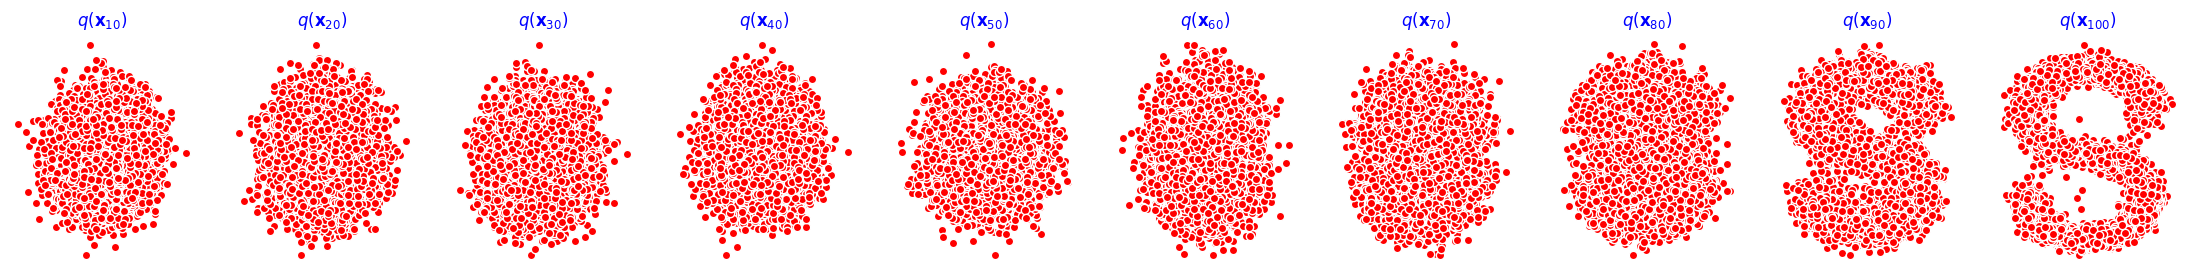

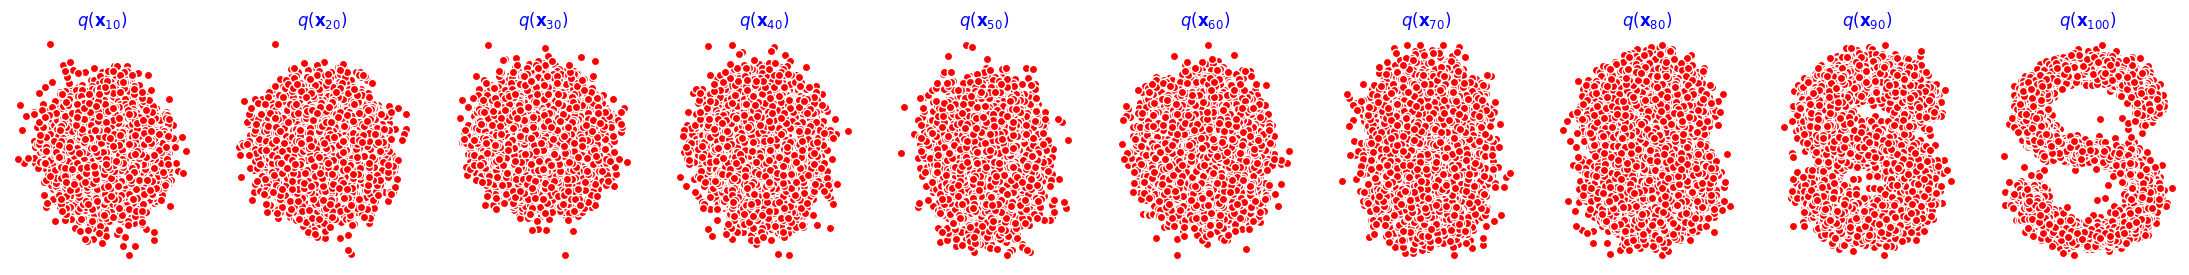

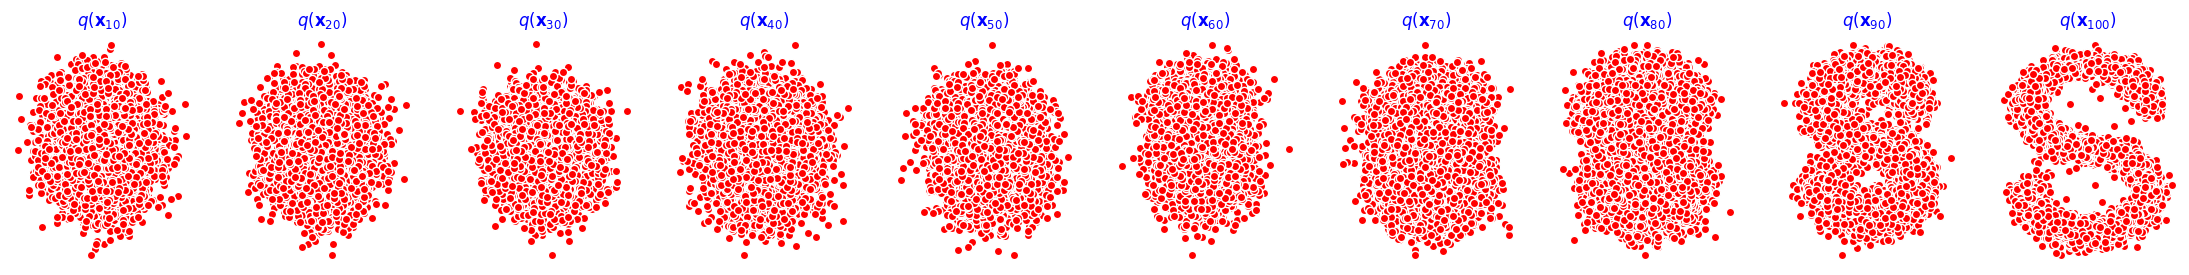

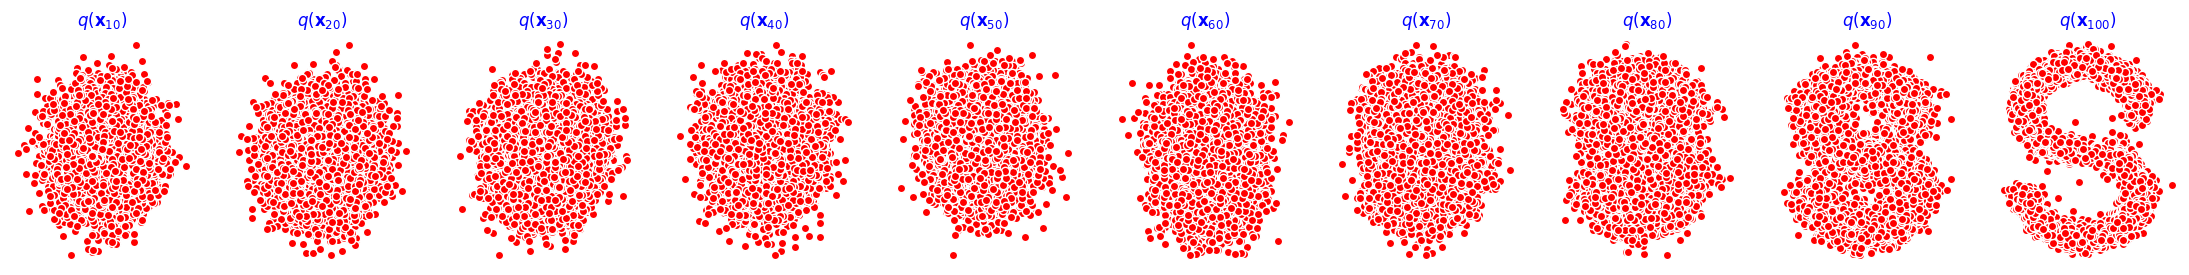

In [10]:
seed = 1234

class EMA():
    """ parameter smoothing """
    def __init__(self, mu=0.01):
        self.mu = mu
        self.shadow = {}

    def register(self, name, val):
        self.shadow[name] = val.clone()

    def __call__(self, name, x):
        assert name in self.shadow
        new_average = self.mu * x + (1.0 - self.mu) * self.shadow[name]
        self.shadow[name] = new_average.clone()
        return new_average
    

print("Training Model...")

batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
num_epoch = 4000
plt.rc("text", color="blue")

model = MLPDiffusion(num_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for t in range(num_epoch):
    for idx, batch_x in enumerate(dataloader):
        loss = loss_func(model, batch_x, alphas_bar_sqrt, one_minus_alphas_bar_sqrt, num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.)
        optimizer.step()

    if (t % 100) == 0:
        print(f"epoch: {t}, Loss: {loss}")
        x_seq = p_sample_loop(model, dataset.shape, num_steps, betas, one_minus_alphas_bar_sqrt)

        fig, axs = plt.subplots(1, 10, figsize=(28,3))
        for i in range(1, 11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0], cur_x[:,1], color='red', edgecolor='white')
            axs[i-1].set_axis_off()
            axs[i-1].set_title("$q(\mathbf{x}_{" + str(i*10) + "})$")


# Animation Demo

## Generating the forward image sequence

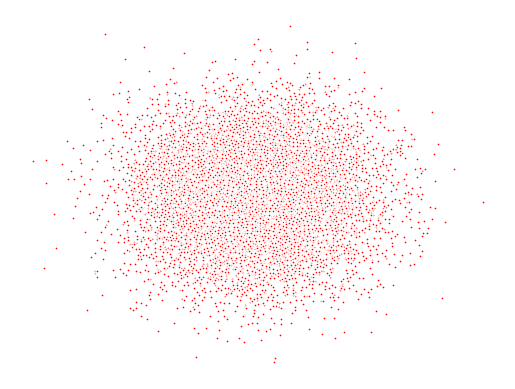

In [11]:
import io
from PIL import Image

imgs = []
for i in range(100):
    plt.clf()
    q_i = q_x(dataset, torch.tensor([i]))
    plt.scatter(q_i[:,0], q_i[:,1], color='red', edgecolor='white', s=5)
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    imgs.append(img)

## Generating the reverse diffusion sequence

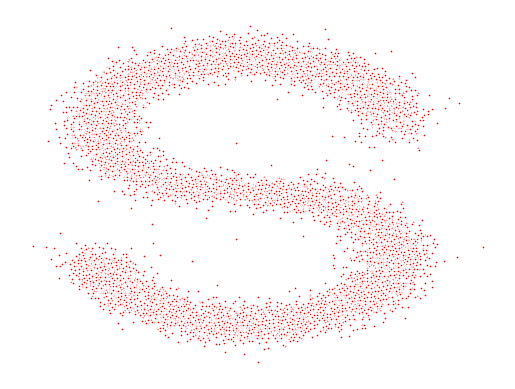

In [12]:
reverse = []
for i in range(100):
    plt.clf()
    current_x = x_seq[i].detach()
    plt.scatter(current_x[:,0], current_x[:,1], color='red', edgecolors='white', s=5)
    plt.axis('off')

    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png')
    img = Image.open(img_buf)
    reverse.append(img)

    

In [13]:
imgs = imgs + reverse
imgs[0].save("diffusion.gif",format='GIF',append_images=imgs,save_all=True,duration=100,loop=0)